In [1]:
import os
os.environ['R_HOME'] = '/data1/lesliec/sneha/anaconda/envs/crc-env/lib/R'
from rpy2.rinterface_lib import openrlib
openrlib.R_HOME = '/data1/lesliec/sneha/anaconda/envs/crc-env/lib/R'
import scanpy as sc
import pandas
import matplotlib.pyplot as plt
import seaborn

In [2]:
%load_ext rpy2.ipython

In [4]:
%%R
library(Matrix)
library(Seurat)
library(ArchR)

In [5]:
adata = sc.read_h5ad('./data/multiome_mouse_4wks_scrna.h5ad')

In [6]:
counts = adata.layers['raw_data'].todense()
obs = adata.obs
umap = adata.obsm['X_umap']
gene_names = adata.var_names

In [7]:
%%R -i counts,obs,umap,gene_names
rownames(counts) <- rownames(obs)
colnames(counts) <- gene_names
counts <- as.matrix(t(counts), sparse=TRUE)
libsizes <- colSums(counts)
size.factors <- libsizes/mean(libsizes)
cpm.counts <- t(t(counts)/size.factors) * 10^6
logcounts <- log(1+cpm.counts)

scrna.object <- CreateSeuratObject(counts=counts, data=logcounts)
scrna.object@meta.data <- obs

umap <- as.matrix(umap)
colnames(umap) <- c('UMAP_1', 'UMAP_2')
rownames(umap) <- colnames(scrna.object)
scrna.object[['UMAP']] <- CreateDimReducObject(embeddings = umap, key = "UMAP_", global = T, assay = "RNA")

R[write to console]: Warning:
R[write to console]:  Data is of class matrix. Coercing to dgCMatrix.



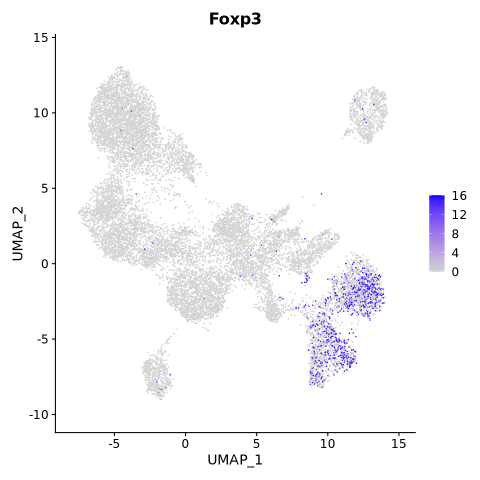

In [8]:
%%R
FeaturePlot(scrna.object, 'Foxp3', slot='data')

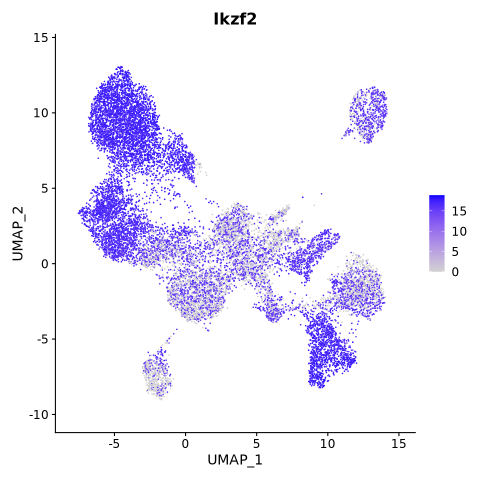

In [9]:
%%R
FeaturePlot(scrna.object, 'Ikzf2')

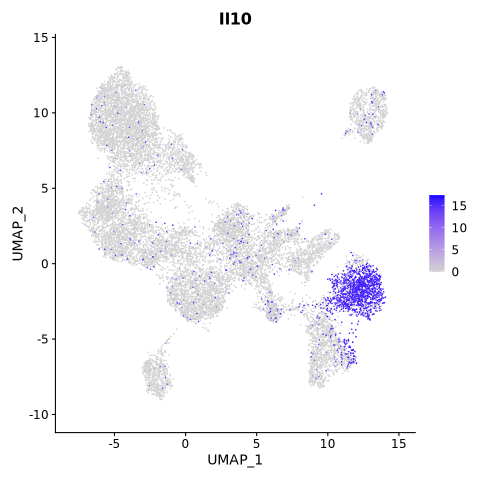

In [10]:
%%R
FeaturePlot(scrna.object, 'Il10')

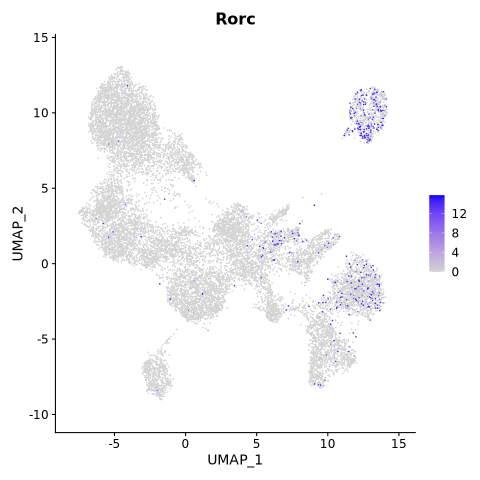

In [11]:
%%R
FeaturePlot(scrna.object, 'Rorc')

In [13]:
%%R
scatac.object <- loadArchRProject('./data/multiome_mouse_4wks_scatac')
#scatac.object <- addCellColData(scatac.object, as.character(scrna.object$celltype_label), 'celltype_label', 
#                                colnames(scrna.object), force=TRUE)
#saveArchRProject(scatac.object, outputDirectory='./data/multiome_mouse_4wks_scatac')

R[write to console]: Successfully loaded ArchRProject!

R[write to console]: 
                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==......\    /                     ||
            ______ =       =|__ /__                     ||      \\\
        ,--' ,----`-,__ ___/'  --,-`-===================##========>
       \               '        ##_______ _____ ,--,__,=##,__   ///
        ,    __==    ___,-,__,--'#'  ==='      `-'    | ##,-/
        -,____,---'       \\####\\________________,--\\_##,/
           ___  

In [14]:
%%R
df_scarlink <- read.table("./data/gene_linked_tiles_celltype_label.csv.gz", sep='\t', header=TRUE)
df_scarlink_subset <- df_scarlink[df_scarlink$celltype_label %in% c("Helios+ Treg", "IL10+ Treg", "PD1+ CD4") & 
                                  df_scarlink$FDR < 0.001 & df_scarlink$z.score > 5,]

In [15]:
%%R
create_loop_granges <- function(df, gene, tss, cluster){
    df_g <- df[df['gene']==gene & df['celltype_label']==cluster,]
    r1 <- as.numeric((df_g$start + df_g$end)/2)
    r2 <- rep(tss, length(r1))
    df_g$end <- pmax(r1, r2)
    df_g$start <- pmin(r1, r2)
    df_g$value <- df_g$z.score
    df_g <- makeGRangesFromDataFrame(df_g, keep.extra.columns=TRUE)
    return(df_g)
}

In [16]:
celltype_colors = adata.uns['celltype_label_colors']
names_celltype_colors = adata.obs['celltype_label'].cat.categories

In [17]:
%%R -i celltype_colors,names_celltype_colors
names(celltype_colors) <- names_celltype_colors

GRanges object with 1 range and 2 metadata columns:
      seqnames          ranges strand |     gene_id      symbol
         <Rle>       <IRanges>  <Rle> | <character> <character>
  [1]     chrX 7579676-7595243      + |       20371       Foxp3
  -------
  seqinfo: 21 sequences from mm10 genome


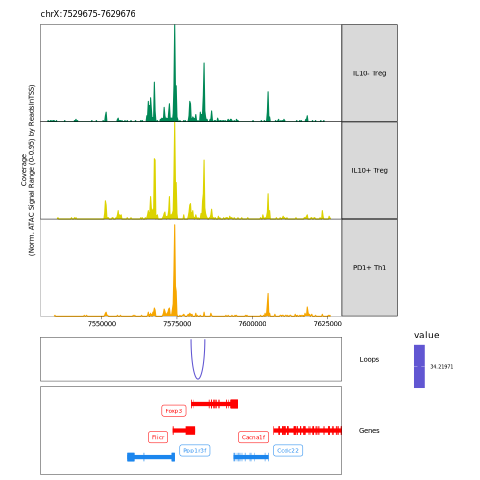

In [18]:
%%R
p <- plotBrowserTrack(
  ArchRProj = scatac.object[scatac.object$celltype_label %in% c("IL10- Treg", "IL10+ Treg", "PD1+ Th1"),],
  geneSymbol = c("Foxp3"),
  groupBy = "celltype_label", pal=celltype_colors,
  #upstream=100000, downstream=100000,
  plotSummary = c("bulkTrack", "loopTrack", "geneTrack"),
  sizes = c(10, 1.5, 3, 4),
  loops = create_loop_granges(df_scarlink_subset, 'Foxp3', 7579676, 'IL10+ Treg')) 
options(repr.plot.width=8, repr.plot.height=2)
grid::grid.newpage()
grid::grid.draw(p$Foxp3)

GRanges object with 1 range and 2 metadata columns:
      seqnames              ranges strand |     gene_id      symbol
         <Rle>           <IRanges>  <Rle> | <character> <character>
  [1]     chr1 131019845-131024970      + |       16153        Il10
  -------
  seqinfo: 21 sequences from mm10 genome


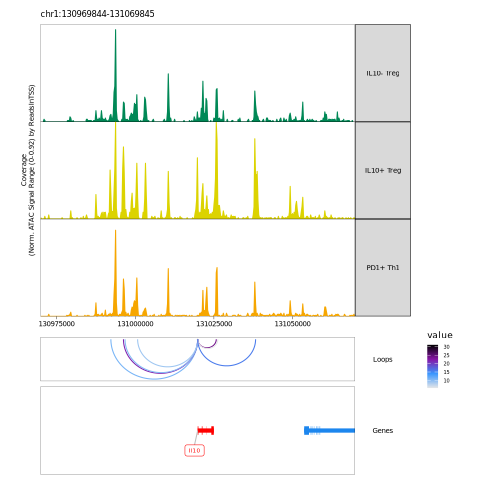

In [19]:
%%R
p <- plotBrowserTrack(
  ArchRProj = scatac.object[scatac.object$celltype_label %in% c("IL10- Treg", "IL10+ Treg", "PD1+ Th1"),],
  geneSymbol = c("Il10"),
  groupBy = "celltype_label", pal=celltype_colors,
  #upstream=100000, downstream=100000,
  plotSummary = c("bulkTrack", "loopTrack", "geneTrack"),
  sizes = c(10, 1.5, 3, 4),
  loops = create_loop_granges(df_scarlink_subset, 'Il10', 131019845, 'IL10+ Treg')) 

options(repr.plot.width=8, repr.plot.height=4)
grid::grid.newpage()
pl <- grid::grid.draw(p$Il10)

GRanges object with 1 range and 2 metadata columns:
      seqnames            ranges strand |     gene_id      symbol
         <Rle>         <IRanges>  <Rle> | <character> <character>
  [1]     chr1 69531207-69685960      - |       22779       Ikzf2
  -------
  seqinfo: 21 sequences from mm10 genome


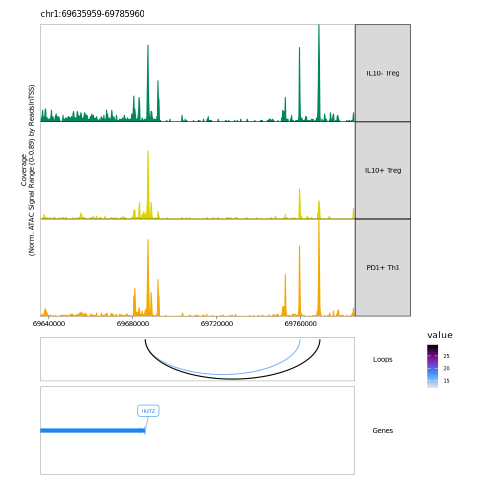

In [20]:
%%R
p <- plotBrowserTrack(
  ArchRProj = scatac.object[scatac.object$celltype_label %in% c("IL10- Treg", "IL10+ Treg", "PD1+ Th1"),],
  geneSymbol = c("Ikzf2"),
  groupBy = "celltype_label", pal=celltype_colors,
  #upstream=100000, downstream=100000,
  plotSummary = c("bulkTrack", "loopTrack", "geneTrack"),
  downstream=100000,
  sizes = c(10, 1.5, 3, 4),
  loops = create_loop_granges(df_scarlink_subset, 'Ikzf2', 69685960, 'Helios+ Treg')) 

options(repr.plot.width=8, repr.plot.height=4)
grid::grid.newpage()
grid::grid.draw(p$Ikzf2)

In [21]:
scarlink_10k = pandas.read_csv("./data/gene_linked_tiles_celltype_label.csv.gz", sep='\t')

In [22]:
df = scarlink_10k[scarlink_10k['Spearman corr'] > 0.1].copy()
df = df[df['celltype_label'].isin(['Helios+ Treg', 'IL10+ Treg'])]
df = df[(df['z-score'] > 0.5) & (df['FDR'] < 0.05)]

In [34]:
df_s[:20]

celltype_label,Helios+ Treg,IL10+ Treg,enh_diff,c
gene,,,,
Rora,19.0,7.0,12.0,Helios+ Treg
Zbtb46,14.0,6.0,8.0,Helios+ Treg
Pdcd1,7.0,0.0,7.0,Helios+ Treg
Smad7,13.0,7.0,6.0,Helios+ Treg
Flnb,10.0,4.0,6.0,Helios+ Treg
Pcgf5,8.0,2.0,6.0,Helios+ Treg
Gata3,11.0,5.0,6.0,Helios+ Treg
H2afz,7.0,1.0,6.0,Helios+ Treg
Stx11,11.0,5.0,6.0,Helios+ Treg


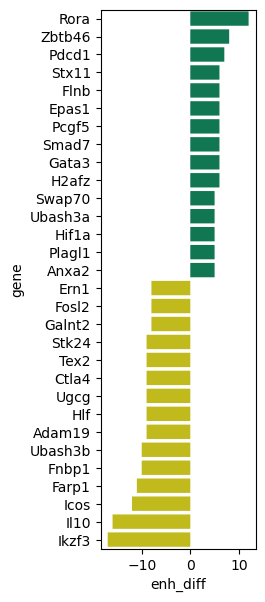

In [36]:
df_s = df.groupby(['celltype_label', 'gene']).size().reset_index(name='counts')
df_s = df_s.pivot(index='gene', columns='celltype_label', values='counts').fillna(0)
df_s['enh_diff'] = df_s['Helios+ Treg'] - df_s['IL10+ Treg']
df_s = df_s.sort_values(by='enh_diff', ascending=False)
df_s['c'] = ['Helios+ Treg' if x > 0 else 'IL10+ Treg' for x in df_s['enh_diff'].values.tolist()]
plt.figure(figsize=(2,7))

# rng = list(range(20)) + list(range(-20,0))
# rng = list(range(15)) + list(range(-15,0))
# df_subset = df_s.iloc[rng]

rng = list(range(25)) + list(range(-25,0))
rng = list(range(20)) + list(range(-20,0))
# different pandas and numpy version ordering rows differently for the same enh. Selecting the genes for the top enh_diff list
# reported in the paper
df_subset = df_s.loc[['Rora', 'Zbtb46', 'Pdcd1', 'Stx11', 'Flnb', 'Epas1', 'Pcgf5', 'Smad7',
       'Gata3', 'H2afz', 'Swap70', 'Ubash3a', 'Hif1a', 'Plagl1', 'Anxa2', 
       'Ern1', 'Fosl2', 'Galnt2', 'Stk24', 'Tex2', 'Ctla4', 'Ugcg', 'Hlf', 'Adam19',
       'Ubash3b', 'Fnbp1', 'Farp1', 'Icos', 'Il10', 'Ikzf3']]

g = seaborn.barplot(x='enh_diff', data=df_subset, y=df_subset.index, hue='c', palette=['#008856', '#DCD300'], snap=False)
s = g.legend_.remove()

In [37]:
adata_s = adata[adata.obs['celltype_label'].isin(['IL10- Treg', 'IL10+ Treg'])].copy()
adata_s.uns['log1p']['base'] = None
sc.tl.rank_genes_groups(adata_s, groupby='celltype_label')
df_g = sc.get.rank_genes_groups_df(adata_s, group='IL10- Treg')

(30, 9)
(30, 4)


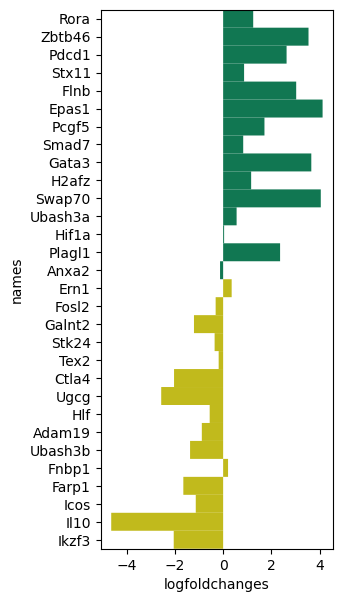

In [38]:
df_g_s = df_g[df_g['names'].isin(df_subset.index.values)]
df_g_s = df_g_s.merge(df_subset, left_on='names', right_index=True)
print(df_g_s.shape)
print(df_subset.shape)
plt.figure(figsize=(3,7))
g = seaborn.barplot(x='logfoldchanges', data=df_g_s, 
                    y='names', order=df_subset.index.values, hue='c', palette=['#008856', '#DCD300'], snap=False,
                   width=1)
s = g.legend_.remove()

In [39]:
modules = {'Ikzf2,Il1rl1,Gata3,Klrg1,Pdcd1': ['Ikzf2', 'Il1rl1', 'Gata3', 'Rel', 'Tox', 'Flnb', 'Tnfrsf9', 'Nfkb1',
       'Tent5a', 'Tmtc2', 'Epas1', 'Rora', 'Il18rap', 'Klrg1', 'Cd83', 'Mgat5',
       'Dgat2', 'Swap70', 'Myo1e', 'Ikzf4', 'Tspan13', 'Dusp10', 'Pdcd1',
       'Gm28112', 'Stat4', 'Pcgf5'],
           'Zbtb46,Itgb8,Il2ra': ['Pkp4', 'Zbtb46', 'Ly75', 'Itgb8', 'Ttn', 'Pcyt1a', 'Gda', 'Il2ra',
       'Uap1', 'Zc3h12c', 'Il18r1', 'Epb41l2', 'Traf3', 'Cep85l', 'Rbpj',
       'Stat1', 'Itgav', 'Ankrd33b', 'Bcl2l1', 'Fam129a', 'Ttc39c', 'Ap3b1',
       'Ppp1r16b', 'Myo10', 'Apaf1', 'Itga4', 'Rnf157', 'Nrip1'],
           'Il10,Maf,Ctla4,Ccr2': ['Il10', 'Maf', 'Ctla4', 'Ccr2', 'Nckap5', 'Ece1', 'Zeb2', 'Itm2b',
       'Ikzf3', 'Rabgap1l', 'Icos', 'Havcr2', 'Gzmb', 'Lag3', 'Gm36975', 'Neb',
       'Gas2', 'Cytip', 'Galnt2', 'Ccr5', 'Il1r1', 'Pde4b', 'Gcnt2', 'Olfr60',
       'Lrrfip2', '4930503L19Rik', 'E130308A19Rik', 'Gm13481', 'Ccr1',
       'Atp10a', 'Snx9', 'Gm49890', 'Agfg1', 'Ppp1r14c', 'Tiparp', 'Il23r',
       'Matn2', 'Rgs1', 'Fmnl2', 'Phactr2', 'Farp1', 'Irak3', 'Eea1',
       'Ubash3b', 'St6galnac3', 'Lamc1', 'Got1', 'Smap2', 'Wdfy2', 'Rbm24',
       'Ston2', 'Adam12', 'Twsg1', 'Hnrnpll', 'Ets2', 'Timp2', 'Dock10',
       'Ier5l', 'Arl4c'],
           'Areg,Il10ra': ['H2afz', 'Tnfrsf4', 'Npnt', 'Nav2', 'Dennd5a', 'Nck2', 'Cd200r1',
       'Dapp1', 'Cd44', 'Ky', 'Hacd3', 'Ptpn13', 'Jak2', 'Gas2l3', 'Mtmr10',
       'Hopx', 'Rapgef2', 'Pxdc1', 'Areg', 'Ntng2', 'Akap12', 'Ppp2r3a',
       'Raph1', 'Pdlim1', 'Tnfrsf18', 'Ttc28', 'Slco3a1', '1700061F12Rik',
       'Bmpr2', 'Slco2b1', 'Gm7247', 'Gpr183', 'Acod1', 'Gm3164', 'Zdhhc23',
       'Pparg', 'Elmo1', 'Il10ra', 'Samsn1', 'Ctsh', 'Fnip2', 'Egln3',
       'Gm3558'],
           'Zeb2,Gzmb,Il23r': ['Nckap5', 'Ece1', 'Zeb2', 'Rabgap1l', 'Havcr2', 'Gzmb', 'Lag3',
       'Gm36975', 'Gas2', 'Il1r1', 'Pde4b', 'Gcnt2', 'Olfr60', '4930503L19Rik',
       'Lrrfip2', 'E130308A19Rik', 'Gm13481', 'Ccr1', 'Atp10a', 'Gm49890',
       'Ppp1r14c', 'Tiparp', 'Il23r', 'Matn2', 'Farp1', 'Phactr2', 'Irak3',
       'Eea1', 'St6galnac3', 'Smap2', 'Wdfy2', 'Rbm24', 'Adam12', 'Twsg1',
       'Ets2', 'Hnrnpll', 'Timp2'],
           'Bcl2': ['Mctp2', 'Pde3b', 'Syde2', 'Bend4', 'Il12rb2', 'Klrd1', 'Atp8b4', 'Lyn',
       'Lrmda', 'Themis', 'Bcl2', 'Cers6', 'Klra6', 'Nr3c1', 'Sidt1', 'Gpr55',
       'Pak1', 'Itga1', 'Klrc1', 'Klrc2', 'Spry2', 'Parp8', 'Kit', 'Cables1',
       'Ncald', 'Prkd3', 'Cd7', 'Klra7', 'Prag1', 'Sox5', 'Fgf13', 'Tspan9',
       'Klra9', '1700025G04Rik', 'Zdhhc14', 'Tmem131l', 'Nmnat2', 'Abr',
       'Klre1', 'Clnk', 'Thada', 'Rbpms', 'Epb41', 'Sipa1l1', 'Litaf',
       'Slc16a10', 'Chn2', 'Klrk1', 'Ppm1h'],
           'S1pr1,Nrp1,Nt5e': ['Adk', 'Aff3', 'Gramd3', 'Bach2', 'S1pr1', 'Trat1', 'Lrig1', 'Ramp3',
       'Rasa3', 'Gm2682', 'Tbc1d4', 'Phlpp1', 'Nrp1', 'Pecam1', 'Arhgap15',
       'Ust', 'Nt5e', 'Prkca', 'Lef1', 'Hivep2', 'Patj', 'Eprs', 'Slamf6',
       'Sh2d1a', 'Sh3rf1', 'St8sia1', 'Ms4a4b', 'Dclk2', 'Adamts6', 'Cmah',
       'Cpm', 'Hipk2', 'Cblb', 'Pde2a', 'Arhgap31', 'Itgb1', 'Zeb1', 'St6gal1',
       'Fyb', 'Skap1', 'Msrb3', 'Klf3', 'Antxr2', 'Stat5b', 'Rras2']
          }

highlight_genes = ['Ikzf2', 'Il1rl1', 'Gata3', 'Klrg1', 'Pdcd1', 'Zbtb46', 'Itgb8', 'Il2ra', 
                       'Il10', 'Maf', 'Ctla4', 'Ccr2', 'Areg', 'Il10ra', 'Zeb2', 'Gzmb', 'Il23r', 'Bcl2', 'S1pr1', 'Nrp1', 
                   'Nt5e']

gene_modules = sum(list(modules.values()), [])
highlight_genes_idx = list(filter(lambda x: gene_modules[x] in highlight_genes, range(len(gene_modules))))

[]

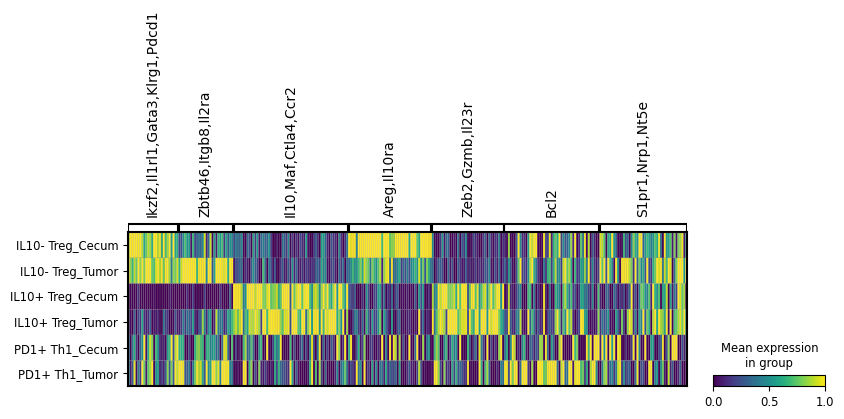

In [40]:
a = sc.pl.matrixplot(adata[adata.obs['celltype_label'].isin(['IL10- Treg', 'IL10+ Treg', 'PD1+ Th1'])], #, 'PD1+ CD4'])],
             modules, figsize=(9, 2),
             groupby=['celltype_label', 'batch'], standard_scale='var', use_raw=True, show=False, #show_gene_labels=False
             categories_order=['IL10- Treg_Cecum', 'IL10- Treg_Tumor', 'IL10+ Treg_Cecum', 'IL10+ Treg_Tumor',
                                 'PD1+ Th1_Cecum', 'PD1+ Th1_Tumor']
        ) 
a['mainplot_ax'].set_xticklabels([])
a['mainplot_ax'].set_xticks([])